# Setting

In [ ]:
#For COLAB
#!pip install gdown
!gdown https://drive.google.com/uc?id=1mWbEcTa0Br0gB4yE67zHzu6NqXlEXl0Y
!unzip Training400.zip


In [2]:
#For COLAB
import os 

DATA_ROOT = "/content"
DATA_DIR_NAME = 'Training400'
DATA_PATH = os.path.join(DATA_ROOT, DATA_DIR_NAME)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


##############################
from pathlib import Path
import os

##############################
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
from matplotlib import patches
##############################

from sklearn.model_selection import train_test_split
###################################################
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model


In [5]:
tf.__version__

'2.4.1'

In [ ]:
# DATA_ROOT = "/Users/macintosh/Desktop"
# DATA_DIR_NAME = 'Training400'
# DATA_PATH = os.path.join(DATA_ROOT, DATA_DIR_NAME)

# Load labels and overview on the data (EDA)

## Load the coordinate of Fovea and add the file path

In [6]:
file_path = Path(DATA_PATH)/'Fovea_location.xlsx'
df = pd.read_excel(file_path)
# need to install xlrd < 2.0 or openpyxl

In [7]:
df.tail()

,ID,imgName,Fovea_X,Fovea_Y
395,396,N0307.jpg,823.024991,690.210211
396,397,N0308.jpg,647.598978,795.653188
397,398,N0309.jpg,624.571803,755.694880
398,399,N0310.jpg,687.523044,830.449187
399,400,N0311.jpg,746.107631,759.623062


**Comment:** 

**- Fovea_X, Fovea_Y are the cordinated of fovea in the eye.**

**- The first letter of imgName give the information of the folder containing the image** 


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       400 non-null    int64  
 1   imgName  400 non-null    object 
 2   Fovea_X  400 non-null    float64
 3   Fovea_Y  400 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 12.6+ KB


In [9]:
df.drop('ID', axis = 1, inplace = True)
df.describe()

,Fovea_X,Fovea_Y
count,400.000000,400.000000
mean,981.477928,957.956941
std,224.119156,192.535779
min,0.000000,0.000000
25%,775.849525,777.529845
50%,1050.598198,1035.870026
75%,1118.199477,1082.806373
max,1995.272727,1374.115464


In [10]:
def fileName_to_filePath(fname):
    if fname[0]=='A':
        dir_name = 'AMD'
    else:
        dir_name = 'Non-AMD'
    file_path = os.path.join(DATA_PATH, dir_name, fname)
    return file_path

In [11]:
df['file_path'] = df['imgName'].apply(fileName_to_filePath)

In [12]:
df.head()

,imgName,Fovea_X,Fovea_Y,file_path
0,A0001.jpg,1182.264278,1022.018842,/content/Training400/AMD/A0001.jpg
1,A0002.jpg,967.754046,1016.946655,/content/Training400/AMD/A0002.jpg
2,A0003.jpg,1220.206714,989.944033,/content/Training400/AMD/A0003.jpg
3,A0004.jpg,1141.140888,1000.594955,/content/Training400/AMD/A0004.jpg
4,A0005.jpg,1127.371832,1071.109440,/content/Training400/AMD/A0005.jpg


Shape of the image

In [13]:
def load_imgsize(file_path):
    #file_path = df.loc[idx, 'file_path']
    with Image.open(file_path) as img:
         return img.size
##Load PIL nhe hon Numpy (mpimg)

In [14]:
#Example: load one image
file_path = df.loc[2, 'file_path']
load_imgsize(file_path)

(2124, 2056)

In [15]:
def add_width_height():
    df['width_height'] = df['file_path'].apply(load_imgsize)
    df['width'] = df['width_height'].apply(lambda row: row[0])
    df['height'] = df['width_height'].apply(lambda row: row[1])
    df.drop('width_height', axis = 1, inplace = True)
    
add_width_height()

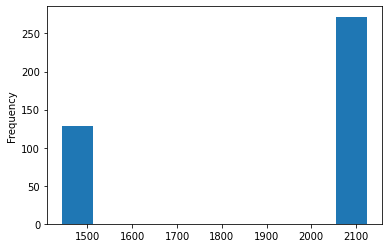

In [16]:
df['width'].plot.hist()

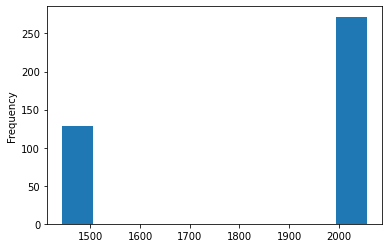

In [17]:
df['height'].plot.hist()

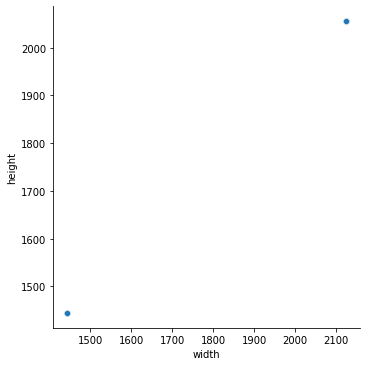

In [18]:
sns.relplot(x='width', y='height', data = df)

## Check if the cordinates of Foera fit the size of the image

In [19]:
assert min(df['width'] -  df['Fovea_X']) >=0
assert min(df['height'] -  df['Fovea_Y']) >=0

## View some images with Fovea (Randomly)

In [20]:
def plot_one_image(idx):
    file_path = df.loc[idx]['file_path']
    with Image.open(file_path) as img:
        plt.imshow(img)
        x = df.loc[idx]['Fovea_X']
        y = df.loc[idx]['Fovea_Y']
        plt.plot(x, y, 'b+', markersize=20)
        name = df.loc[idx]['imgName']
        plt.title(name)

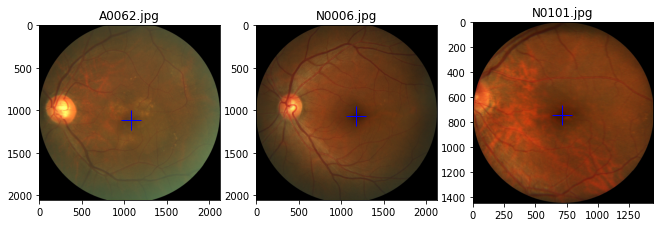

In [21]:
#show three images randomly
fig = plt.gcf() 
fig.set_size_inches(11,8)
for i in range(3):
    idx = np.random.choice(df.shape[0])
    plt.subplot(1,3,i+1)
    plot_one_image(idx)

# Creat Datasets

## Load all images and change labels to RATE (independent of resize image effect)

In [22]:
def load_one_img(img_path, resize_shape):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = resize_shape) #target_size = (256, 256)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img
    
def load_all_imgs(img_paths, resize_shape):
    all_img = [load_one_img(img_path, resize_shape) for img_path in img_paths]
    return np.array(all_img)

img_paths = df.file_path
resize_shape = (150, 150)
all_imgs = load_all_imgs(img_paths, resize_shape)

In [23]:
df["rate_Fovea_X"] = df["Fovea_X"] / df['width']
df["rate_Fovea_Y"] = df["Fovea_Y"] / df['height']

In [24]:
bdf.head()

,imgName,Fovea_X,Fovea_Y,file_path,width,height,rate_Fovea_X,rate_Fovea_Y
0,A0001.jpg,1182.264278,1022.018842,/content/Training400/AMD/A0001.jpg,2124,2056,0.556622,0.497091
1,A0002.jpg,967.754046,1016.946655,/content/Training400/AMD/A0002.jpg,2124,2056,0.455628,0.494624
2,A0003.jpg,1220.206714,989.944033,/content/Training400/AMD/A0003.jpg,2124,2056,0.574485,0.481490
3,A0004.jpg,1141.140888,1000.594955,/content/Training400/AMD/A0004.jpg,2124,2056,0.537260,0.486671
4,A0005.jpg,1127.371832,1071.109440,/content/Training400/AMD/A0005.jpg,2124,2056,0.530778,0.520968


In [26]:
all_labels = df[['rate_Fovea_X', 'rate_Fovea_Y']].values.astype('float32')

 ## Split data

In [27]:
id_full = list(range(df.shape[0]))

id_train, id_test = train_test_split(id_full, test_size = 0.2, 
                                     shuffle = True, random_state = 42)

In [28]:


labels_train = all_labels[id_train]
labels_test = all_labels[id_test]

imgs_train = all_imgs[id_train]
imgs_test = all_imgs[id_test]


In [29]:
imgs_train.shape, labels_train.shape

((320, 150, 150, 3), (320, 2))

## Transformation and Augmentation

In [30]:
def preprocess_with_augmentation(image, x, y, is_training = True):
    image = image/255.0  
    if is_training:
        rand = tf.random.uniform(shape= [1])
        if rand>=0.5:
            image = tf.image.random_flip_left_right(image)
            x = 1-x
    return image, (x, y)

## Train and Test DS

In [31]:
def creat_dataset(imgs, labels, batch_size, is_training = True):
    ds = tf.data.Dataset.from_tensor_slices((imgs, labels[:,0], labels[:,1]))
    ds = ds.map(lambda imgs, x, y: preprocess_with_augmentation(imgs, x, y, is_training))
    if is_training:
        buffer_size = 1000
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(-1)
    return ds

In [32]:
ds_train = creat_dataset(imgs_train, labels_train, batch_size = 64, is_training = True)
ds_test = creat_dataset(imgs_test, labels_test, batch_size = 32, is_training = False)

In [33]:
ds_train.element_spec

(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

# Two models for trainning

## GHI CHÚ

## Model 1: Using Transfer Learning (InceptionV3)

## Model architecture

In [34]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,                     
    weights = 'imagenet' #None 
)

for layer in pre_trained_model.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
# last_layer = pre_trained_model.get_layer('mixed7') # take the layer with the name 'mixed7'
# last_output = last_layer.output

In [38]:
x = Flatten()(pre_trained_model.output) 
x = Dense(1024, activation='relu')(x)
#x = layers.Dropout(0.2)(x)  
output = Dense(2)(x)

model = Model(pre_trained_model.input, output)
model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

## Training preocess

In [ ]:
history = model.fit(ds_train, 
          epochs = 20,
          validation_data = ds_test
          )

In [44]:
mse      = history.history[ 'mse' ]
val_mse  = history.history[ 'val_mse' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

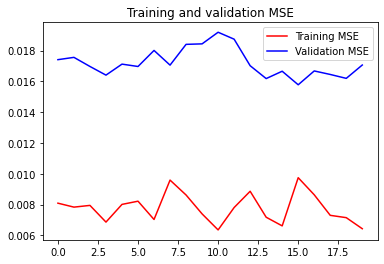

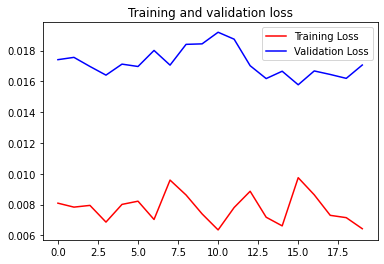

In [45]:
epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 2: A simple Resnet from scratch

In [ ]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add() # take a sum
    
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

In [ ]:
class Simple_ResNet(tf.keras.Model):
    def __init__(self):
        super(Simple_ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dens1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dens2 = tf.keras.layers.Dense(2)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        x = self.dens1(x)
        x = self.dens2(x)
        return x

In [ ]:
my_model = Simple_ResNet()
my_model.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse'])

In [ ]:
history2 = my_model.fit(ds_train, 
          epochs = 100,
          validation_data = ds_test
          )

Epoch 1/100
5/5 [==============================] - 3s 249ms/step - loss: 0.3100 - mse: 0.3100 - val_loss: 0.2688 - val_mse: 0.2688
Epoch 2/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.2185 - val_mse: 0.2185
Epoch 3/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.2088 - val_mse: 0.2088
Epoch 4/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.1946 - val_mse: 0.1946
Epoch 5/100
5/5 [==============================] - 1s 154ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.1878 - val_mse: 0.1878
Epoch 6/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.1832 - val_mse: 0.1832
Epoch 7/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.1684 - val_mse: 0.1684
Epoch 8/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0069 - m

In [ ]:
mse      = history.history[ 'mse' ]
val_mse  = history.history[ 'val_mse' ]
loss     = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]

In [ ]:
epochs = range(len(mse))

plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()